<a href="https://colab.research.google.com/github/jhuang59/PersonalizationEngineNeuralNetwork/blob/main/classification_of_learning_style_using_dl.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px

import re
import nltk
import string

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow import keras
from keras.layers import Dense, LSTM, Embedding, Bidirectional
from keras.models import Sequential

# Allows us to connect to our google drive
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
 #extra nltk libraries needed
 nltk.download('omw-1.4')
 nltk.download('wordnet')
 nltk.download('stopwords')
 nltk.download('punkt')

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

## Data First look

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/VAK_Learning_Styles.csv')

In [ ]:
nRow, nCol = df.shape
print(f'There are {nRow} rows and {nCol} columns')

There are 15450 rows and 2 columns


In [ ]:
df.sample(5)

,Sentence,Type
15294,We are trying to create a place of contemplati...,Kinesthetic
3999,A woman who decides not to observe the rituals...,Visual
3703,"In the first pair of lines, Wagner uses allite...",Visual
9818,"All right, already! Let me finish what I was d...",Auditory
13353,The fact that the Communist Party is not elect...,Kinesthetic


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15450 entries, 0 to 15449
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Sentence  15450 non-null  object
 1   Type      15450 non-null  object
dtypes: object(2)
memory usage: 241.5+ KB


#### ☝Comment:
No missing Values, No need to encode the data

## Data Wrangling

In [ ]:
df['Sentence'].isnull().sum()


0

In [ ]:
df['Sentence'].duplicated().sum()

856

#### ☝Comment:
Seems that we have duplicated values in our dataset, therefor, we will to drop them to avoid misleading informations

In [ ]:
df.drop_duplicates(inplace=True,keep=False)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14595 entries, 0 to 15449
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Sentence  14595 non-null  object
 1   Type      14595 non-null  object
dtypes: object(2)
memory usage: 342.1+ KB


### Convert the entire text into lower case

In [ ]:
df['new_Sentence'] = df['Sentence'].apply(lambda x:x.lower())

### Perform Lemmatization

In [ ]:
lemm=WordNetLemmatizer()

In [ ]:
df['new_Sentence'] = df['new_Sentence'].apply(lambda x:lemm.lemmatize(x))

### Remove StopWords

In [ ]:
stop_words = stopwords.words("english")

In [ ]:
def remove_stopwords(text):
    no_stop = []
    for word in text.split(' '):
        if word not in stop_words:
            no_stop.append(word)
    return " ".join(no_stop)


In [ ]:
df['new_Sentence'] = df['new_Sentence'].apply(remove_stopwords)

### Remove unwanted text- Text Cleaning

In [ ]:
def clean_text(text):
    text = re.sub(r'[^a-zA-Z ]', '', text)
    return text

str_punc = string.punctuation.replace(',', '').replace("'",'')

In [ ]:
df['new_Sentence'] = df['new_Sentence'].apply(clean_text)

### Removes all punctuation from a string, if present

In [ ]:
def remove_punctuation_func(text):
    return re.sub(r'[^a-zA-Z0-9]', ' ', text)

In [ ]:
df['new_Sentence'] = df['new_Sentence'].apply(remove_punctuation_func)

In [ ]:
df.sample(5)

,Sentence,Type,new_Sentence
5166,He continues to show steady progress and is de...,Visual,continues show steady progress developing conf...
11144,Because interpretation is as much grounded in ...,Kinesthetic,interpretation much grounded emotional apprehe...
3076,"For example, imagine a line of cards with rand...",Visual,example imagine line cards random numbers writ...
13456,"And even if they keep the world guessing, ambi...",Kinesthetic,even keep world guessing ambiguities often put...
3443,"But whenever I asked if I might do something, ...",Visual,whenever asked might something rollerskate aro...


In [ ]:
def tokenize_text(df, input_col='new_Sentence', output_col="cleaned_word_list"):
    """
    takes a dataset and name of a column
    then tokenizes the text in the column of that dataset
    """
    df.loc[:, output_col] = df.loc[:, input_col].apply(lambda t: word_tokenize(t))
    return df

df = tokenize_text(df)

In [ ]:
df.sample(5)

,Sentence,Type,new_Sentence,cleaned_word_list
1258,Males in many lekking species have conspicuous...,Visual,males many lekking species conspicuous morphol...,"[males, many, lekking, species, conspicuous, m..."
10472,"She's easy to be with, provided you don't mind...",Auditory,easy with provided mind constant chatter nonse...,"[easy, with, provided, mind, constant, chatter..."
3510,"Thoroughly impractical, hideous to look at and...",Visual,thoroughly impractical hideous look and appare...,"[thoroughly, impractical, hideous, look, and, ..."
9321,"Ker-thump, shatter, shatter, Ker-thump, shatte...",Auditory,kerthump shatter shatter kerthump shatter soun...,"[kerthump, shatter, shatter, kerthump, shatter..."
13122,The drop in pressure immediately boils some of...,Kinesthetic,drop pressure immediately boils water steam le...,"[drop, pressure, immediately, boils, water, st..."


## EDA

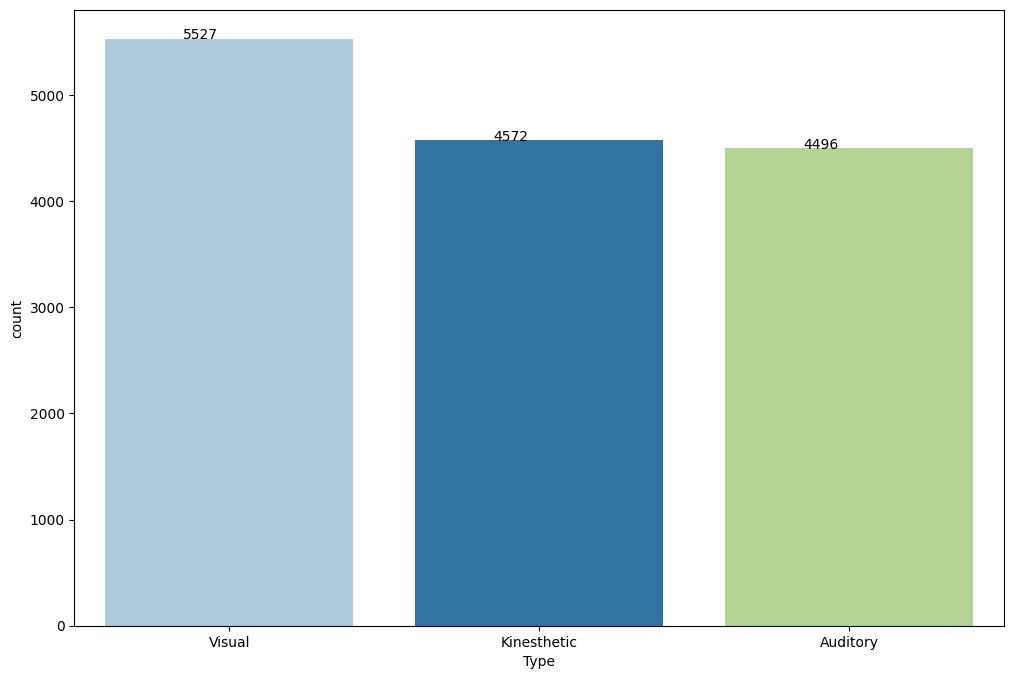

In [ ]:
import seaborn as sns

plt.figure(figsize=(12,8))
ax = sns.countplot(x=df["Type"],  data=df, order = df["Type"].value_counts().index,palette="Paired" )
for p, label in zip(ax.patches,df["Type"].value_counts()):
    ax.annotate(label, (p.get_x()+0.25, p.get_height()+0.5))

#### ☝Comment:
Data is decently balanced, No need to be handled

#### 👇Comment:
distribution of the sentence length

<Axes: >

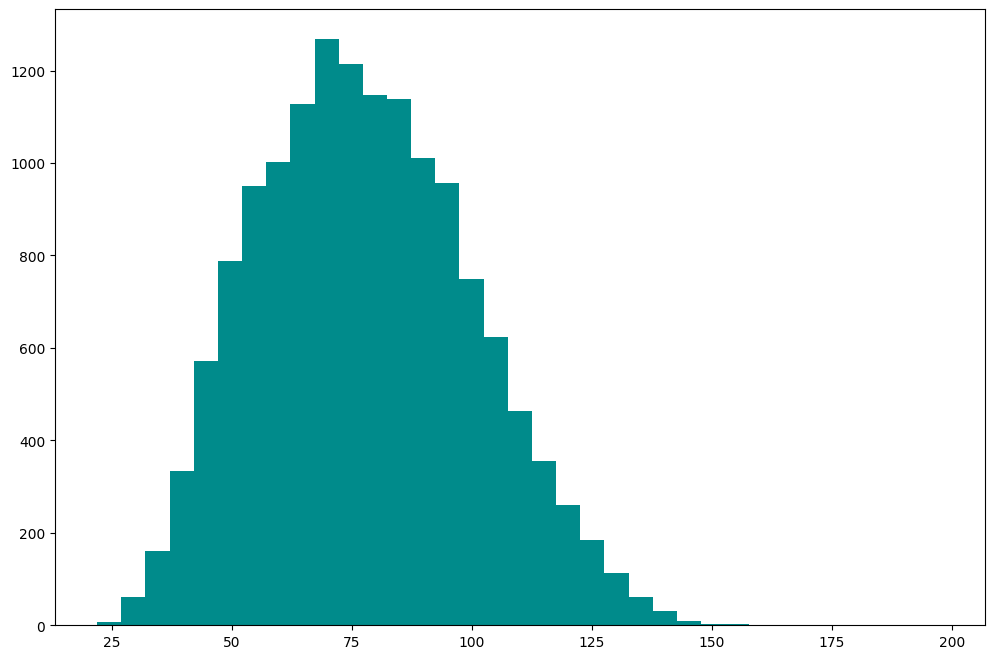

In [ ]:
df['new_Sentence'].str.len().hist(bins = 35 ,figsize=(12,8),color= "DarkCyan", grid = False)

In [ ]:
dataset_aud = df[df['Type'] == 'Auditory']
dataset_vis = df[df['Type'] == 'Visual']
dataset_kin = df[df['Type'] == 'Kinesthetic']

In [ ]:
def count_words(tokens_arrays):

    count_dict = {}
    for array_ in tokens_arrays:
        for word in array_:
            try: count_dict[word] +=1
            except: count_dict[word] = 1

    # sort
    sorted_count_dict = {k:v for k,v in sorted(count_dict.items(), key=lambda item: item[1], reverse=True)}

    return sorted_count_dict

In [ ]:
def get_n_key_and_value(n, dict_):

    keys = [k for (k, v) in dict_.items()][:n]
    values = [v for (k, v) in dict_.items()][:n]

    return keys, values

In [ ]:
def convert_tokens_list_to_freq_df(tokens_arrays, n=-1):

    dict_ = count_words(tokens_arrays)
    keys, values = get_n_key_and_value(n, dict_)

    df = pd.DataFrame({'words': keys, 'freq': values})

    return df

dataset_aud_words_freq = convert_tokens_list_to_freq_df(dataset_aud.cleaned_word_list)
dataset_vis_words_freq = convert_tokens_list_to_freq_df(dataset_vis.cleaned_word_list)
dataset_kin_words_freq = convert_tokens_list_to_freq_df(dataset_kin.cleaned_word_list)


### create TFIDF (Term Frequency – Inverse Document Frequency) scores

In [ ]:
def get_tfidf_words_and_array(text_arrays):

    vectorizer = TfidfVectorizer()
    transformed_data = vectorizer.fit_transform(text_arrays).toarray()
    words = vectorizer.get_feature_names_out()

    return transformed_data, words

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

def create_tfidf_df(text_arrays):

    transformed_data, words = get_tfidf_words_and_array(text_arrays)

    df = pd.DataFrame(data=transformed_data, columns=words).sum().reset_index()

    col_names = ['words', 'tfidf_score_sum']
    default_col_names = df.columns

    # rename whatever the df cols are called to the col_names
    df.rename(columns={default_col_names[i]:col_names[i] for i in range(len(col_names))}, inplace=True)

    return df

In [ ]:
tfidf_scores_aud = create_tfidf_df(dataset_aud.loc[:, 'new_Sentence'])
tfidf_scores_vis = create_tfidf_df(dataset_vis.loc[:, 'new_Sentence'])
tfidf_scores_kin = create_tfidf_df(dataset_kin.loc[:, 'new_Sentence'])

In [ ]:
def merge(df_1, df_2, on='words'):
    return pd.merge(left=df_1, right=df_2, on=on, how='left')

In [ ]:
aud_words_df = merge(dataset_aud_words_freq, tfidf_scores_aud)
vis_words_df = merge(dataset_vis_words_freq, tfidf_scores_vis)
kin_words_df = merge(dataset_kin_words_freq, tfidf_scores_kin)

In [ ]:
aud_words_df.head()

,words,freq,tfidf_score_sum
0,sound,409,59.829099
1,voice,367,58.487375
2,hear,336,54.856894
3,noise,331,53.601806
4,say,329,54.096589


In [ ]:
n = 15

fig = px.bar(
    data_frame=aud_words_df[:n], x='words', y='freq', color='freq',
    text='tfidf_score_sum', labels={'x': 'words', 'y': 'frequency'},
    title='Frequency of words seen in <b> Auditory </b>Learning Type (with TFIDF Scors)' )

fig.update_xaxes(tickangle= -45)
fig.update_traces(
    texttemplate='%{text:.2f}', textposition='outside',
     textfont_size=8)

fig.show()

In [ ]:
n = 15

fig = px.bar(
    data_frame=vis_words_df[:n], x='words', y='freq', color='freq',
    text='tfidf_score_sum', labels={'x': 'words', 'y': 'frequency'},
    title='Frequency of words seen in <b> Visual </b>Learning Type (with TFIDF Scors)' )

fig.update_xaxes(tickangle= -45)
fig.update_traces(
    texttemplate='%{text:.2f}', textposition='outside',
     textfont_size=8)

fig.show()

In [ ]:
n = 20

fig = px.bar(
    data_frame=kin_words_df[:n], x='words', y='freq', color='freq',
    text='tfidf_score_sum', labels={'x': 'words', 'y': 'frequency'},
    title='Frequency of words seen in <b> Kinesthetic </b>Learning Type (with TFIDF Scors)' )

fig.update_xaxes(tickangle= -45)
fig.update_traces(
    texttemplate='%{text:.2f}', textposition='outside',
     textfont_size=8)

fig.show()

## Text Preparation to train Deep Learning Model

In [ ]:
X = df['new_Sentence']
y = df['Type']

### Tokenize words

In [ ]:
le = LabelEncoder()
y = le.fit_transform(y)
y = to_categorical(y)


text_train, text_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Tokenize words
tokenizer = Tokenizer()
tokenizer.fit_on_texts(text_train)
sequences_train = tokenizer.texts_to_sequences(text_train)
sequences_test = tokenizer.texts_to_sequences(text_test)
X_train = pad_sequences(sequences_train, maxlen=48, truncating='pre')
X_test = pad_sequences(sequences_test, maxlen=48, truncating='pre')

vocabSize = len(tokenizer.index_word) + 1
print(f"Vocabulary Size = {vocabSize}")

Vocabulary Size = 26651


In [ ]:
vocabSize

26638

### Read GloVE embeddings

In [ ]:
path_to_glove_file = '/content/drive/MyDrive/Colab Notebooks/glove.6B.200d.txt'
num_tokens = vocabSize
embedding_dim = 200
hits = 0
misses = 0
embeddings_index = {}

# Read word vectors
with open(path_to_glove_file,encoding="utf8") as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs
print("Found %s word vectors." % len(embeddings_index))

embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1

Found 400000 word vectors.


## Build neural network architecture

In [ ]:
model = Sequential()
model.add(Embedding(vocabSize, 200, input_length=X_train.shape[1], weights=[embedding_matrix], trainable=False))
model.add(LSTM(256, dropout=0.2,recurrent_dropout=0.2, return_sequences=True))
model.add(LSTM(128, dropout=0.2,recurrent_dropout=0.2))
model.add(Dense(3, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 48, 200)           5330200   
                                                                 
 lstm (LSTM)                 (None, 48, 256)           467968    
                                                                 
 lstm_1 (LSTM)               (None, 128)               197120    
                                                                 
 dense (Dense)               (None, 3)                 387       
                                                                 
Total params: 5995675 (22.87 MB)
Trainable params: 665475 (2.54 MB)
Non-trainable params: 5330200 (20.33 MB)
_________________________________________________________________


In [ ]:
history = model.fit(X_train,
                    y_train,
                    validation_data=(X_test, y_test),
                    verbose=1,
                    batch_size=64,
                    epochs=10)

Epoch 1/10
183/183 [==============================] - 106s 513ms/step - loss: 0.6380 - accuracy: 0.7338 - val_loss: 0.4492 - val_accuracy: 0.8321
Epoch 2/10
183/183 [==============================] - 90s 487ms/step - loss: 0.3393 - accuracy: 0.8732 - val_loss: 0.1958 - val_accuracy: 0.9308
Epoch 3/10
183/183 [==============================] - 86s 471ms/step - loss: 0.1676 - accuracy: 0.9441 - val_loss: 0.1541 - val_accuracy: 0.9459
Epoch 4/10
183/183 [==============================] - 85s 463ms/step - loss: 0.0997 - accuracy: 0.9668 - val_loss: 0.0959 - val_accuracy: 0.9644
Epoch 5/10
183/183 [==============================] - 86s 470ms/step - loss: 0.0749 - accuracy: 0.9734 - val_loss: 0.0996 - val_accuracy: 0.9657
Epoch 6/10
183/183 [==============================] - 85s 467ms/step - loss: 0.0546 - accuracy: 0.9800 - val_loss: 0.0821 - val_accuracy: 0.9719
Epoch 7/10
183/183 [==============================] - 86s 471ms/step - loss: 0.0436 - accuracy: 0.9838 - val_loss: 0.0704 - val_a

## Visualize Loss & Accuracy

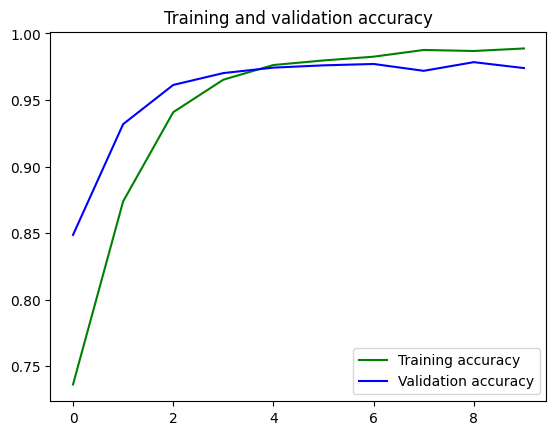

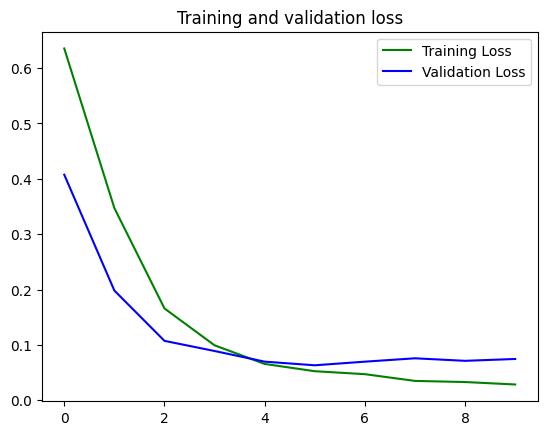

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'g', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'g', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
loss, acc=model.evaluate(X_test, y_test, verbose=1)

92/92 [==============================] - 3s 37ms/step - loss: 0.0765 - accuracy: 0.9740


In [ ]:
print (f"Test Loss = {round(loss,2)} %")
print (f"Test Accuracy = {round(acc,2)} %")

Test Loss = 0.08 %
Test Accuracy = 0.97 %


## Model Demo

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px

import re
import nltk
#extra nltk libraries needed
nltk.download('omw-1.4')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')
import string

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow import keras
from keras.layers import Dense, LSTM, Embedding, Bidirectional
from keras.models import Sequential

# Allows us to connect to our google drive
from google.colab import drive
drive.mount('/content/drive')


[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Mounted at /content/drive


In [ ]:
# Library to avoid the warnings
import warnings
warnings.filterwarnings("ignore")

# Libraries to help with reading and manipulating data
import numpy as np
import pandas as pd

# To define maximum number of columns to be displayed in a dataframe
pd.set_option("display.max_columns", None)

# Libraries to help with data visualization
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Importing math module to perform mathematical operations
import math

import re
import nltk                   #Natural language processing tool-kit

nltk.download('stopwords')    #download stopwords
nltk.download('punkt')
nltk.download('wordnet')

from wordcloud import WordCloud,STOPWORDS #importing wordcloud and stopwords

from sklearn.feature_extraction.text import CountVectorizer          #For Bag of words
from sklearn.feature_extraction.text import TfidfVectorizer          #For TF-IDF

!pip install vaderSentiment    # Install vader sentiment package
!pip install textblob   # Install textblob package
!pip install contractions

import re, string, unicodedata                          # Import Regex, string and unicodedata.
import contractions                                     # Import contractions library.
from bs4 import BeautifulSoup                           # Import BeautifulSoup.

from nltk.corpus import stopwords                       # Import stopwords.
from nltk.tokenize import word_tokenize, sent_tokenize  # Import Tokenizer.
from nltk.stem import PorterStemmer                     # Stemmer
from nltk.stem.wordnet import WordNetLemmatizer         # Import Lemmatizer.


from sklearn.ensemble import RandomForestClassifier       # Import Random forest Classifier
from sklearn.metrics import classification_report         # Import Classification report
from sklearn.model_selection import KFold , StratifiedKFold, cross_val_score # Importing cross validation
from sklearn.utils import class_weight # Importing class weight to help balance out features if they're imbalanced

# Importing backend
from tensorflow.keras import backend

# Sklearn modules
from sklearn.preprocessing import LabelBinarizer                                                 # Importing the preprocessing module to preprocess the data
from sklearn.model_selection import train_test_split                                             # Importing train_test_split function to split the data into train and test

#To import different metrics
from sklearn.metrics import (
    explained_variance_score,
    mean_squared_error,
    r2_score,
    mean_absolute_error,
    f1_score,
    accuracy_score,
    recall_score,
    precision_score,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    confusion_matrix,
    classification_report
)

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.8/110.8 kB 13.8 MB/s eta 0:00:00


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/VAK_Learning_Styles.csv')

In [ ]:
df2 = df.copy()

#dropping duplicates
df2.drop_duplicates(inplace=True,keep=False)

In [ ]:
#Text Preprocessing 1

#remove the html tags
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

#expand the contractions
def replace_contractions(text):
    """Replace contractions in string of text"""
    return contractions.fix(text)

#remove the numericals present in the text
def remove_numbers(text):
  text = re.sub(r'\d+', '', text)
  return text

#function to implement all the above functions and return the cleaned text
def clean_text(text):
    text = strip_html(text)
    text = replace_contractions(text)
    text = remove_numbers(text)
    return text

#applying the functions to the text column
df2['new_Sentence'] = df2['Sentence'].apply(lambda x: clean_text(x))

In [ ]:
#tokenization
df2['new_Sentence'] = df2.apply(lambda row: nltk.word_tokenize(row['new_Sentence']), axis=1) # Tokenization of data

In [ ]:
#Text Preprocessing 2

#setting all the stop words
stop_words = stopwords.words('english')
stop_words = list(set(stop_words))

#creating variable for lemmatizer
lemmatizer = WordNetLemmatizer()

#remove the non-ASCII characters
def remove_non_ascii(words):
    """Remove non-ASCII characters from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_words.append(new_word)
    return new_words

# convert all characters to lowercase
def to_lowercase(words):
    """Convert all characters to lowercase from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = word.lower()
        new_words.append(new_word)
    return new_words

# Remove the punctuations
def remove_punctuation(words):
    """Remove punctuation from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            new_words.append(new_word)
    return new_words

# Remove the stop words
def remove_stopwords(words):
    """Remove stop words from list of tokenized words"""
    new_words = []
    for word in words:
        if word not in stop_words:
            new_words.append(word)
    return new_words

# lemmatize the words
def lemmatize_list(words):
    new_words = []
    for word in words:
      new_words.append(lemmatizer.lemmatize(word, pos='v'))
    return new_words

#function to implement all above functions and return the final piece of text
def normalize(words):
    words = remove_non_ascii(words)
    words = to_lowercase(words)
    words = remove_punctuation(words)
    words = remove_stopwords(words)
    words = lemmatize_list(words)
    return ' '.join(words)

#applying all functions to the text column
df2['new_Sentence'] = df2.apply(lambda row: normalize(row['new_Sentence']), axis=1)


In [ ]:
df2.head()

,Sentence,Type,new_Sentence
0,"Ali, who was two at the time, loved the story ...",Auditory,ali two time love story little girl live teeny...
1,"Look at my dad, spiffed up in jodhpurs, ready ...",Auditory,look dad spiffed jodhpurs ready ride bay mare ...
2,Believe me it's far more difficult to know wha...,Auditory,believe far difficult know say unconscious lov...
3,"The Surrealists loved bad movies, seeing them ...",Auditory,surrealists love bad movies see subversive att...
4,"He idolised prize-fighters, regarded racketeer...",Auditory,idolise prizefighters regard racketeer friends...


In [ ]:
#model prep

#Defining X and y
X = df2['new_Sentence']
y = df2['Type']

#encoding y
le = LabelEncoder()
y1 = le.fit_transform(y)
y2 = to_categorical(y1)

text_train, text_test, y_train, y_test = train_test_split(X, y2, test_size=0.2)

# Tokenize words
tokenizer = Tokenizer()
tokenizer.fit_on_texts(text_train)
sequences_train = tokenizer.texts_to_sequences(text_train)
sequences_test = tokenizer.texts_to_sequences(text_test)
X_train = pad_sequences(sequences_train, maxlen=48, truncating='pre')
X_test = pad_sequences(sequences_test, maxlen=48, truncating='pre')

#splitting the dataset
#X2_train, X2_test, y_train, y_test = train_test_split(X2, y2, test_size=0.20, random_state=1, shuffle=False)


In [ ]:
y.size

14595

In [ ]:
vocabSize = len(tokenizer.index_word) + 1
print(f"Vocabulary Size = {vocabSize}")

path_to_glove_file = '/content/drive/MyDrive/Colab Notebooks/glove.6B.200d.txt'
num_tokens = vocabSize
embedding_dim = 200
hits = 0
misses = 0
embeddings_index = {}

# Read word vectors
with open(path_to_glove_file,encoding="utf8") as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs
print("Found %s word vectors." % len(embeddings_index))

embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1

Vocabulary Size = 24724
Found 400000 word vectors.


In [ ]:
#model building
model = Sequential()
model.add(Embedding(vocabSize, 200, input_length=X_train.shape[1], weights=[embedding_matrix], trainable=False))
model.add(LSTM(256, dropout=0.2,recurrent_dropout=0.2, return_sequences=True))
model.add(LSTM(128, dropout=0.2,recurrent_dropout=0.2))
model.add(Dense(3, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 48, 200)           4944800   
                                                                 
 lstm_6 (LSTM)               (None, 48, 256)           467968    
                                                                 
 lstm_7 (LSTM)               (None, 128)               197120    
                                                                 
 dense_3 (Dense)             (None, 3)                 387       
                                                                 
Total params: 5610275 (21.40 MB)
Trainable params: 665475 (2.54 MB)
Non-trainable params: 4944800 (18.86 MB)
_________________________________________________________________


In [ ]:
history = model.fit(X_train,
                    y_train,
                    validation_data=(X_test, y_test),
                    verbose=1,
                    batch_size=64,
                    epochs=10)

Epoch 1/10
183/183 [==============================] - 85s 430ms/step - loss: 0.9153 - accuracy: 0.5682 - val_loss: 0.7510 - val_accuracy: 0.6944
Epoch 2/10
183/183 [==============================] - 81s 441ms/step - loss: 0.6428 - accuracy: 0.7404 - val_loss: 0.4937 - val_accuracy: 0.8064
Epoch 3/10
183/183 [==============================] - 81s 443ms/step - loss: 0.3899 - accuracy: 0.8585 - val_loss: 0.2937 - val_accuracy: 0.8880
Epoch 4/10
183/183 [==============================] - 78s 426ms/step - loss: 0.2365 - accuracy: 0.9131 - val_loss: 0.1935 - val_accuracy: 0.9308
Epoch 5/10
183/183 [==============================] - 80s 435ms/step - loss: 0.1462 - accuracy: 0.9461 - val_loss: 0.1645 - val_accuracy: 0.9390
Epoch 6/10
183/183 [==============================] - 79s 434ms/step - loss: 0.1024 - accuracy: 0.9640 - val_loss: 0.1469 - val_accuracy: 0.9496
Epoch 7/10
183/183 [==============================] - 78s 429ms/step - loss: 0.0813 - accuracy: 0.9687 - val_loss: 0.1378 - val_ac

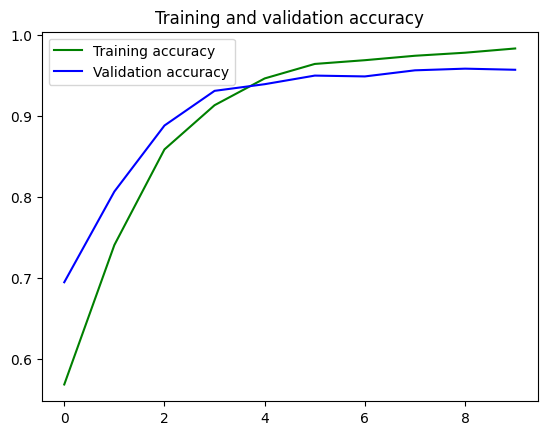

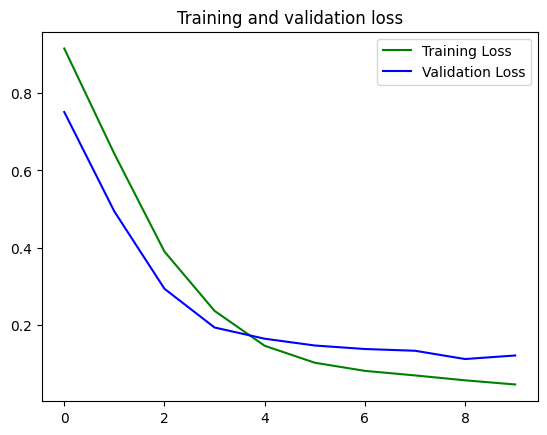

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'g', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'g', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
loss, acc=model.evaluate(X_test, y_test, verbose=1)
print (f"Test Loss = {round(loss,2)} %")
print (f"Test Accuracy = {round(acc,2)} %")

92/92 [==============================] - 3s 35ms/step - loss: 0.1211 - accuracy: 0.9568
Test Loss = 0.12 %
Test Accuracy = 0.96 %


In [ ]:
#Saving the model

"""import joblib
filename = 'learning_style_class.sav'
joblib.dump(model, filename)"""

"""import pickle
filename = 'ls_class.sav'
filepath = '/content/drive/MyDrive/Colab Notebooks/learning_style_class.sav'
pickle.dump(model, open(filepath, 'wb'))"""

model.save('/content/drive/MyDrive/Colab Notebooks/ls_class_model.keras')

In [ ]:
#loading the model
"""import joblib
loaded_model = joblib.load('/content/drive/MyDrive/Colab Notebooks/learning_style_class.sav')
#result = loaded_model.evaluate(X_test, y_test)
#print(result)"""

"""import pickle
filepath = '/content/drive/MyDrive/Colab Notebooks/learning_style_class.sav'
loaded_model = pickle.load(open(filepath, 'rb'))
#result = loaded_model.evaluate(X_test, y_test)
#print(result)"""
loaded_model = keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/ls_class_model.keras')

In [ ]:
loaded_model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 48, 200)           5347400   
                                                                 
 lstm_8 (LSTM)               (None, 48, 256)           467968    
                                                                 
 lstm_9 (LSTM)               (None, 128)               197120    
                                                                 
 dense_4 (Dense)             (None, 3)                 387       
                                                                 
Total params: 6012875 (22.94 MB)
Trainable params: 665475 (2.54 MB)
Non-trainable params: 5347400 (20.40 MB)
_________________________________________________________________


In [ ]:
loaded_model.evaluate(X_test, y_test)

92/92 [==============================] - 12s 134ms/step - loss: 4.7569 - accuracy: 0.3683


[4.756906986236572, 0.36827680468559265]

In [ ]:
stop_words = stopwords.words("english")

def remove_stopwords(text):
    no_stop = []
    for word in text.split(' '):
        if word not in stop_words:
            no_stop.append(word)
    return " ".join(no_stop)

def clean_text(text):
    text = re.sub(r'[^a-zA-Z ]', '', text)
    return text

def remove_punctuation_func(text):
    return re.sub(r'[^a-zA-Z0-9]', ' ', text)

y = df2['Type']
tokenizer = Tokenizer()
le = LabelEncoder()
y = le.fit_transform(y)
y = to_categorical(y)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14595 entries, 0 to 15449
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Sentence  14595 non-null  object
 1   Type      14595 non-null  object
dtypes: object(2)
memory usage: 342.1+ KB


In [ ]:
def ls_class(text):
  #print(text)
  text = clean_text(text)
  text = remove_stopwords(text)
  text = remove_punctuation_func(text)
  text = tokenizer.texts_to_sequences([text])
  text = pad_sequences(text, maxlen=48, truncating='pre')
  result = le.inverse_transform(np.argmax(model.predict(text), axis=-1))[0]
  print("Based on your response, you have the following learning style: ", f"{result} \n")
  #print(text)

"""def ls_class(text):
  #print(text)
  text = clean_text(text)
  text = normalize(text)
  text = tokenizer.texts_to_sequences([text])
  text = pad_sequences(text, maxlen=48, truncating='pre')
  result = le.inverse_transform(np.argmax(model.predict(text), axis=-1))[0]
  print("Based on your response, you have the following learning style: ", f"{result} \n")
  #print(text)"""

user_input = input("Briefly describe how you like to learn: ")

ls_class(user_input)

Briefly describe how you like to learn: I like to watch video content to learn new things!
1/1 [==============================] - 0s 70ms/step
Based on your response, you have the following learning style:  Visual 



In [ ]:
sentences = [
             "Brilliant! I can't wait to hear the news about this change!", # Auditory
             "Chill out guys, nothing's gonna change, we have to study hard to succeed", # Kinesthetic
             "Can you imagine how this idea's gonna change the education system!" # Visual
            ]
for sentence in sentences:
    print(sentence)
    sentence = clean_text(sentence)
    #sentence = normalize(sentence)
    sentence = remove_stopwords(sentence)
    sentence = remove_punctuation_func(sentence)
    sentence = tokenizer.texts_to_sequences([sentence])
    sentence = pad_sequences(sentence, maxlen=48, truncating='pre')
    result   = le.inverse_transform(np.argmax(loaded_model.predict(sentence), axis=-1))[0]
    print(f"{result} \n")

Brilliant! I can't wait to hear the news about this change!
1/1 [==============================] - 0s 61ms/step
Kinesthetic 

Chill out guys, nothing's gonna change, we have to study hard to succeed
1/1 [==============================] - 0s 68ms/step
Visual 

Can you imagine how this idea's gonna change the education system!
1/1 [==============================] - 0s 75ms/step
Visual 



### <span  style="color:red">Thank You.</span>